In [1]:
#Bayesian statistics approach for direct fitting
#Should be run in our IoA virtual machines



In [3]:
#importing
import numpy as np
import astropy.io.fits as fits
import matplotlib.pyplot as plt 
import pandas as pd
from astropy.stats import sigma_clip
from astropy.modeling import models,fitting
from scipy.ndimage import uniform_filter1d
from scipy.stats import norm
from scipy.special import voigt_profile
from scipy import signal
from scipy.signal import correlate
from PyAstronomy import pyasl
from scipy.optimize import curve_fit
from astropy.time import Time
import astropy.units as u
from astropy.coordinates import SkyCoord, EarthLocation
from astropy.constants import c
import astropy.io.fits as fits
from astropy.units import dimensionless_unscaled
from lmfit.models import LinearModel, GaussianModel, VoigtModel, PolynomialModel
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
import glob
import fnmatch
import os
from astropy.timeseries import LombScargle
from plotnine import *
import traceback
import sys
import linecache
import textwrap
import re
import emcee
import corner
import tqdm
from multiprocessing import Pool


""" 
plt.rcParams['axes.linewidth'] = 1.25
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 1.25
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1.25

default_settings = {
    'font.size': 16,
    'axes.linewidth': 0.8,
    'xtick.major.size': 3.5,
    'xtick.major.width': 1,
    'ytick.major.size': 3.5,
    'ytick.major.width': 1
}


initial_settings = {
    'font.size': 22,
    'axes.linewidth': 1.25,
    'xtick.major.size': 5,
    'xtick.major.width': 1.25,
    'ytick.major.size': 5,
    'ytick.major.width': 1.25
}
plt.rcParams.update(default_settings)
"""

" \nplt.rcParams['axes.linewidth'] = 1.25\nplt.rcParams['xtick.major.size'] = 5\nplt.rcParams['xtick.major.width'] = 1.25\nplt.rcParams['ytick.major.size'] = 5\nplt.rcParams['ytick.major.width'] = 1.25\n\ndefault_settings = {\n    'font.size': 16,\n    'axes.linewidth': 0.8,\n    'xtick.major.size': 3.5,\n    'xtick.major.width': 1,\n    'ytick.major.size': 3.5,\n    'ytick.major.width': 1\n}\n\n\ninitial_settings = {\n    'font.size': 22,\n    'axes.linewidth': 1.25,\n    'xtick.major.size': 5,\n    'xtick.major.width': 1.25,\n    'ytick.major.size': 5,\n    'ytick.major.width': 1.25\n}\nplt.rcParams.update(default_settings)\n"

In [4]:
#salt read in data
def Get_Wavelength_Flux_File(filename) :
    # Get the wavelength and flux from a MIDAS pipeline file
    hdulist = fits.open(filename)
    header = hdulist[0].header
    date_obs = header.get('DATE-OBS', None)
    time_obs = header.get('TIME-OBS',None)
    time = Time(str(date_obs) + 'T' + str(time_obs), format='fits')
    #time = Time(date_obs,format = "fits")
    
    flux = hdulist[0].data # flux in counts 
    
    CRVAL1 = hdulist[0].header['CRVAL1'] # Coordinate at reference pixel
    CRPIX1 = hdulist[0].header['CRPIX1'] # Reference pixel
    CDELT1 = hdulist[0].header['CDELT1'] # Coordinate increase per pixel
    HEL_COR = hdulist[0].header['HEL_COR'] # Heliocentric correction
    OBJECT = str(header.get("OBJECT", None))
    
    # Need to use the info above to make the wavelength axis
    wavelength = np.zeros(len(flux))
    print(f"The reference pixel in timefile: {time} is {CRPIX1}")
    for i in range(len(wavelength)) :
        #heliocentric correction
        wavelength[i] = (CRVAL1 + CDELT1*i) + (HEL_COR/299792 )*(CRVAL1 + CDELT1*i) - (CRPIX1*CDELT1)
        #wavelength[i] = (CRVAL1 + CDELT1*i)
    
    hdulist.close()	

    return wavelength, flux, time, OBJECT

In [5]:
#line dictionaries: Name, position(A), present?, log gf
#if you want to add a line to be used in the model, change the corresponding line in the dictionary to True instead of False
p_lines = []
spec_lines = []

#pollutant lines
p_lines.append(("CaII_3933", 3933.663, False)) #only use for MIKE data
p_lines.append(("CaII_4226",4226.727, False)) #good
p_lines.append(("FeII_4923",4923.927, False)) #can't use, crosses over with interorder
p_lines.append(("FeII_5018",5018.440, False))#not there
p_lines.append(("FeII_5169",5169.033, False)) #this one gives an error when trying to fit it
p_lines.append(("SiII_5041",5041.024, False)) #don't use this
p_lines.append(("SiII_5055",5055.984, True)) #This one is good use it
p_lines.append(("SiII_5957",5957.560, True))
p_lines.append(("SiII_5978",5978.930, True))
p_lines.append(("SiII_6347",6347.100, True)) #these two are quite strong in WD1929+012
p_lines.append(("SiII_6371",6371.360, True)) #
p_lines.append(("MgI_5172",5172.683, False))
p_lines.append(("MgI_5183",5183.602, False))
p_lines.append(("MgII_4481",4481.130,True)) #strong magnesium line
p_lines.append(("MgII_4481_2",4481.327, False))
p_lines.append(("MgII_4481",4481.180,False)) #weighted combination of mg_4481 lines

p_lines.append(("MgII_7877",7877.054, False)) 
p_lines.append(("MgII_7896",7896.366, False)) #definitely not present
p_lines.append(("OI_7771",7771.944, False)) #definitely not present
#hydrogen lines
p_lines.append(("H_4860",4860.680, False))
p_lines.append(("H_4860_2",4860.968, True))#This one gives better values
p_lines.append(("H_4860_2",4860.968, False))#Weighted combo
p_lines.append(("H_4340",4340.472,False)) #present
p_lines.append(("H_6563",6562.79 ,False)) #not present in the 2020 spectra?
#pick the spectral lines present in this white dwarf

for i in p_lines:
    if i[2] == True:
        spec_lines.append(i)

b_lines = []
r_lines = []
for i in spec_lines:
    if i[1] <= 5550:
        #370 - 555 nm
        b_lines.append(i)
    else:
        #555 - 890 nm
        r_lines.append(i)

#Now define the sky lines that we will use to find the stability corrections from the instrument variability

sky_lines = []
sky_lines.append(("OI_5577",5577.340))
sky_lines.append(("OI_6300",6300.304))
sky_lines.append(("OI_6364",6363.776))
#sky_lines.append(("H2O_7392"))
#sky_lines.append(("H2O_8365"))


In [6]:
#calculate errors - faster

def calculate_error(data):
    window_size = int(500)
    # Use a rolling window approach for efficient calculation of standard deviation
    #least mean squared method
    rolling_std = np.sqrt(np.convolve(data**2, np.ones(window_size) / window_size, mode='valid') - np.convolve(data, np.ones(window_size) / window_size, mode='valid')**2)
    
    # Extend the result to match the original length of the data
    pad_width = window_size // 2
    errors = np.pad(rolling_std, (pad_width, pad_width), mode='edge')
    #print(len(errors),len(data))
    errorsv = np.nan_to_num(errors)
    #print(np.mean(errorsv))
    return errorsv[:len(data)]


In [7]:
def poly_fit(gwav,gdata):
    poly_model = PolynomialModel(degree=7)
    params = poly_model.guess(gdata, x=gwav)
    poly_result = poly_model.fit(gdata, params, x=gwav)
    print(poly_result.params['c0'],poly_result.params['c1'],poly_result.params['c2'],poly_result.params['c3'],poly_result.params['c4'])
    
    #find the individual polynomial best fit
    c0 = poly_result.params['c0'].value
    c1 = poly_result.params['c1'].value
    c2 = poly_result.params['c2'].value
    c3 = poly_result.params["c3"].value
    c4 = poly_result.params["c4"].value
    c5 = poly_result.params["c5"].value
    c6 = poly_result.params["c6"].value
    c7 = poly_result.params["c7"].value
    
    p_result = c0 + c1 * gwav + c2 * gwav**2 + c3 * gwav**3 + c4 * gwav**4 + c5 * gwav**5 + c6 * gwav**6 + c7 * gwav**7
    """ 
    plt.figure()
    plt.plot(gwav, p_result, color='green', linewidth=1)
    plt.plot(gwav, gdata, color='blue', linewidth=0.5)
    plt.show()
    """

    return p_result

In [8]:
#function to pick the files that we want and make dictionaries of them

def pick_files_by_patterns(folder_path, start_patterns, end_patterns):
   
    matching_files = []

    # Ensure the folder path is valid
    if not os.path.isdir(folder_path):
        print(f"Error: {folder_path} is not a valid directory.")
        return matching_files

    for folder_name in os.listdir(folder_path):
        fp = os.path.join(folder_path, folder_name,"product/")

        # List all files in the folder
        try:
            all_files = os.listdir(fp)
        except FileNotFoundError:
            continue
        except NotADirectoryError:
            continue

        # Filter files based on start patterns
        #for start_pattern in start_patterns:
        #   matching_files.extend(fnmatch.filter(all_files, start_pattern + '*'))

        # Filter files based on end patterns
        #for end_pattern in end_patterns:
         #   matching_files.extend(fnmatch.filter(all_files, '*' + end_pattern))
        for file in all_files:
            if file.startswith(start_patterns) and file.endswith(end_patterns):
                matching_files.append(os.path.join(fp, file))

    return matching_files


def mike_pick_files_by_patterns(folder_path, start_patterns, end_patterns):
    matching_files = []
    # Ensure the folder path is valid
    if not os.path.isdir(folder_path):
        print(f"Error: {folder_path} is not a valid directory.")
        return matching_files
    try:
        for file_name in os.listdir(folder_path):
            matching_files.append(os.path.join(folder_path, file_name))
    except FileNotFoundError:
        # Handle the case where the folder doesn't exist
        print(f"The folder '{folder_path}' does not exist.")
        return None
    
    # Return the list of matching files
    return matching_files

# Example usage:

#This is where we pick the folder path and the name of the file that we want
#Need to adjust this so that it is more clear
star = "WD1929+012"
SALT_folder_path = "/data/wdplanetary/omri/Data/WD1929+012/"
MIKE_blue_folder_path = "/data/wdplanetary/laura/MIKE/Data/WD1929+011/blue/"
MIKE_red_folder_path = "/data/wdplanetary/laura/MIKE/Data/WD1929+011/red/"


blue_start = ("mbgphH")
red_start =  ("mbgphR")
end_patterns = ("u2wm.fits")  #End pattern for the object fiber
sky_end_patterns = ("u1wm.fits") #End pattern for the sky fiber
merged_end_patterns = ("uwm.fits") #end pattern for the reduced fiber
mike_start = ("gal")
mike_end = (".fits")

#Creating file directory for the blue and red channels separately
b_files = pick_files_by_patterns(SALT_folder_path, blue_start, end_patterns)
merged_b_files = pick_files_by_patterns(SALT_folder_path, blue_start, merged_end_patterns)
r_files = pick_files_by_patterns(SALT_folder_path, red_start, end_patterns)
sky_r_files = pick_files_by_patterns(SALT_folder_path, red_start, sky_end_patterns)
mike_b_files = mike_pick_files_by_patterns(MIKE_blue_folder_path, mike_start,mike_end)
mike_r_files = mike_pick_files_by_patterns(MIKE_red_folder_path, mike_start,mike_end)

b_files.sort()
r_files.sort()
sky_r_files.sort()
mike_b_files.sort()
mike_r_files.sort()
bad_date = ['/data/wdplanetary/omri/Data/WD1929+012/2019-1-SCI-008.20190513',
            '/data/wdplanetary/omri/Data/WD1929+012/2020-1-SCI-043.20200531',
            '/data/wdplanetary/omri/Data/WD1929+012/2018-1-SCI-043.20180605',
            '/data/wdplanetary/omri/Data/WD1929+012/2019-2-SCI-049.20200824',
            '/data/wdplanetary/omri/Data/WD1929+012/2017-1-SCI-031.20170813/product/mbgphH20170813003'
            ]

b_files = [f for f in b_files if not any(f.startswith(start) for start in bad_date)]
r_files = [f for f in r_files if not any(f.startswith(start) for start in bad_date)] 
sky_r_files = [f for f in sky_r_files if not any(f.startswith(start) for start in bad_date)] 
merged_b_files = [f for f in merged_b_files if not any(f.startswith(start) for start in bad_date)]


The reference pixel in timefile: 2017-07-14T21:38:23.304 is 1.0
<Parameter 'c0', value=-474548.344031728 +/- 127, bounds=[-inf:inf]> <Parameter 'c1', value=712.5222533502528 +/- 0.132, bounds=[-inf:inf]> <Parameter 'c2', value=-0.4579587920489541 +/- 4.36e-05, bounds=[-inf:inf]> <Parameter 'c3', value=0.0001633322326876904 +/- nan, bounds=[-inf:inf]> <Parameter 'c4', value=-3.491098809906462e-08 +/- nan, bounds=[-inf:inf]>
number of lines: 3
---------
the starting values are[36, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.6, 0.6, 0.6, 5055.984, 4481.13, 4860.968, 0, 0, 0]
---------
The lines we are using, and their minimum/maximum wavelengths are: [5055.984 4481.13  4860.968]
[5055.784 4480.93  4860.768]
[5056.184 4481.33  4861.168]


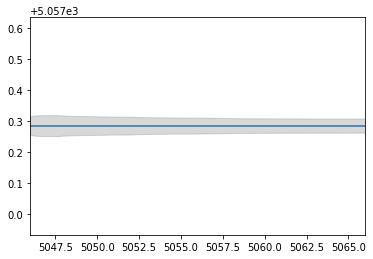

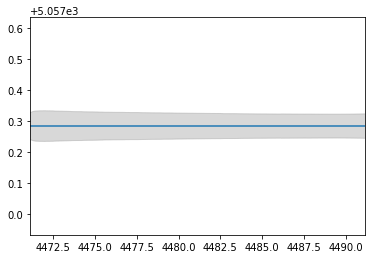

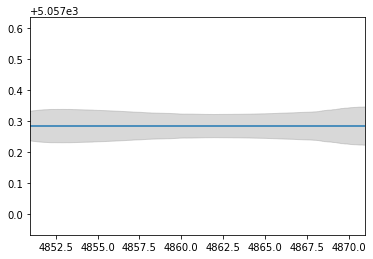

100%|██████████| 2000/2000 [01:07<00:00, 29.42it/s]


State([[ 3.59999838e+01  2.99988385e-01  2.99980182e-01  3.00106098e-01
   2.99785814e-01  3.00054039e-01  2.99857720e-01  5.99912493e-01
   5.99901832e-01  5.99981609e-01  5.05598417e+03  4.48112974e+03
   4.86096815e+03 -9.49560320e-05  5.94126722e-05  1.36881879e-04]
 [ 3.59999147e+01  2.99901385e-01  2.99979481e-01  2.99921247e-01
   3.00178980e-01  2.99869653e-01  3.00008670e-01  6.00160787e-01
   6.00184689e-01  6.00054422e-01  5.05598406e+03  4.48113009e+03
   4.86096812e+03 -1.40919452e-05  2.09046348e-05 -4.03761888e-05]
 [ 3.60000047e+01  3.00058555e-01  2.99912293e-01  2.99934124e-01
   2.99914977e-01  2.99928467e-01  3.00007264e-01  5.99820195e-01
   5.99990974e-01  5.99958338e-01  5.05598405e+03  4.48112997e+03
   4.86096804e+03 -2.52343310e-04 -3.42021179e-05  4.71704556e-05]
 [ 3.59999525e+01  3.00137460e-01  3.00035279e-01  3.00009346e-01
   2.99805010e-01  2.99775534e-01  2.99926885e-01  5.99991975e-01
   5.99916621e-01  6.00029440e-01  5.05598404e+03  4.48113010e+03
 

In [9]:
#Bayesian statistics model initialization, data calling, and running


#importing, cropping, and normalising data
wav,flux,t,star = Get_Wavelength_Flux_File("/data/wdplanetary/omri/Data/WD1929+012/2017-1-SCI-031.20170714/product/mbgphH201707140017_u2wm.fits")
#rwav,rflux,t,star = Get_Wavelength_Flux_File("/data/wdplanetary/omri/Data/WD1929+012/2017-1-SCI-031.20170711/product/mbgphR201707110020_u2wm.fits")
#wav = np.concatenate((bwav,rwav))
#flux = np.concatenate((bflux,rflux))
#lower bound of window
u_loc = np.searchsorted(wav, 5200) #5200
closest_value = wav[max(0, u_loc-1)]
u_bound = np.where(wav == closest_value)
u_bound = int(u_bound[0])
#find the lower bound of the window
l_loc = np.searchsorted(wav, 4100) #4100
closest_value = wav[max(0, l_loc-1)]
l_bound = np.where(wav == closest_value)
l_bound = int(l_bound[0])
y = flux[l_bound:u_bound]
l = wav[l_bound:u_bound]
p_result = poly_fit(l,y)
D = y/p_result
sigma = calculate_error(D)/2

#initilizing values
#priors for the values
#gaussian profile for line centre with the x as a function
c_vals = []
c_priors_list = []
lines = ([i[1] for i in b_lines])
c1 = np.array(lines)

#first attempt to make gaussian priors, now doing inside the logprior function
""" 
for j in c1:
    gaussian = (norm.pdf(D, j, 0.04)) #make a prior function for the line 
    plt.plot(D,gaussian)
    plt.show()
    sum = np.sum(gaussian)
    c_priors_list.append(sum)
 """

n = len(c1)
print(f"number of lines: {n}")
#initial values for each line 
rv = 36
#sigma = 0.03
s1 = np.full((n,), 0.3)
g1 = np.full((n,), 0.3)
d1 = np.full((n,), 0.6)
offset = np.full((n,), 0)


#make an array for the initial parameters, some of these are lists and some are scalars
arrays_theta = [rv, s1, g1, d1, c1,offset]  # Assuming theta is a list containing both scalar values and arrays/lists
theta = []  # Initialize an empty list to store the expanded values
# Iterate through each element in theta
for item in arrays_theta:
    # Check if the current item is an array/list
    if isinstance(item, (list, np.ndarray)):
        # If it is an array/list, extend the expanded_theta list with its elements
        theta.extend(item)
    else:
        # If it's a scalar value, append it directly to the expanded_theta list
        theta.append(item)
print("---------")
print(f"the starting values are{theta}")
print("---------")
#limits on the priors
cmin = c1 - 0.2
cmax = c1 + 0.2
print(f"The lines we are using, and their minimum/maximum wavelengths are: {c1}")
print(f"{cmin}")
print(f"{cmax}")
smin = 0 #sigma of the fit
smax = 1
gmin = 0 #gamma of the fit
gmax = 1
dmin = 0 #depth of the fit
dmax = 2
offset_min = -0.2 #offset of the fit
offset_max = 0.2
Delta_min = 0 #RV shift
Delta_max = 60



def f(l, theta):
    #function to generate the model
    Delta = float(theta[0])
    s = theta[1::5]
    g = theta[2::5]
    d = theta[3::5]
    c = theta[4::5]
    offset_values = theta[5::5] 
    model = 1 + np.sum([offset - (voigt_profile((l-(ci*(1+Delta/299792.0))),si, gi )) for ci, si,gi, di,offset in zip(c, s,g, d,offset_values)], axis=0)
    return model

#test plot to see how the model looks like compared to the spectrum 
for i in lines:
    plt.plot(l, f(l,theta))
    #plt.plot(l,D)
    plt.fill_between(l,f(l,theta) - sigma, f(l,theta) + sigma, color='gray', alpha=0.3)
    plt.xlim(i -10,i +10 )
    #plt.ylim(0.4,1.6)
    plt.show()
    

#minimum and maximum arrays for initial values
prior_mini = np.array([Delta_min] + [smin,gmin, dmin, offset_min]*n ) 
prior_min = np.concatenate((prior_mini,cmin))

prior_maxi = np.array([Delta_max] + [smax,gmax, dmax, offset_max ]*n )
prior_max = np.concatenate((prior_maxi,cmax))


def log_likelihood(theta, l, D,sigma):
    residual = D - f(l, theta[:-1])
    return -0.5 * np.sum((residual / sigma)**2 + np.log(2 * np.pi * sigma**2))

# Define the log prior function
def log_prior(theta):
    total_log_prior = 0
    #defining priors again
    Delta = theta[0]
    s_values = theta[1::n]
    g_values = theta[2::n]
    d_values = theta[3::n]
    c_values = theta[4::n]
    offset_values = theta[5::n] 

    #setting the logprior to False if outside the priors
    if not (Delta_min < Delta < Delta_max):
        return -np.inf
    if not (Delta_min < Delta < Delta_max):
        return -np.inf

    for (s,g, d,c,offs,c_init) in (zip(s_values, g_values, d_values,c_values,offset_values, c1)):
        #adding priors
        c_prior_logpdf = np.sum(norm.logpdf(c, loc = c_init,scale = 0.04))
        total_log_prior += c_prior_logpdf

        offset_prior_logpdf = np.sum(norm.logpdf(offset, loc = 0,scale = 0.2))
        total_log_prior += offset_prior_logpdf

        #restricting for bounds on parameters
        if not (smin < s < smax) or not (gmin < g < gmax) or not (dmin < d < dmax) or not (c_init -0.5 < c < c_init+0.5) or not (offset_min < offs < offset_max):
            return -np.inf
    #adding a logprior function
    
    #prior_mu = norm.logpdf(theta[0], loc=0, scale=1)
    
    return total_log_prior

# Define the log posterior function
def log_probability(theta, l, D, sigma):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, l, D, sigma)



# Initialize walker positions using Latin hypercube sampling - also works - different way to initialize the sampling
""" 
from pyDOE import lhs
nwalkers = 64
ndim = len(theta)  # Assuming n is defined elsewhere
bounds = np.array([prior_min, prior_max]).T  # Define bounds for each parameter
lhs_samples = lhs(ndim, samples=nwalkers)
data = pd.DataFrame(lhs_samples)
pos = bounds[:, 0] + lhs_samples * (bounds[:, 1] - bounds[:, 0])
 """

 
#initialise walkers and pos using normal gaussian distributions
pos = (theta) + 1e-4 * np.random.randn(3*len(theta), len(theta))
nwalkers, ndim = pos.shape 



# Run the sampler
nsteps = 2000
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(l,D,sigma))
sampler.run_mcmc(pos, nsteps, progress=True)




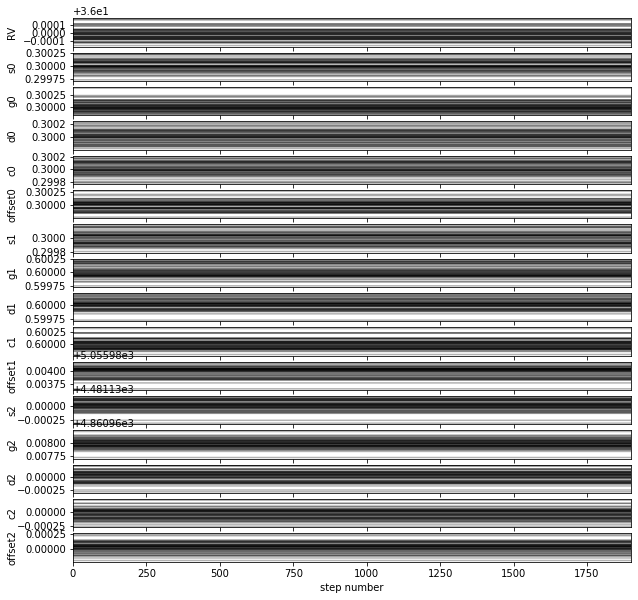

[[ 3.59999147e+01  2.99898248e-01  2.99907727e-01  2.99897573e-01
   2.99907269e-01  2.99883717e-01  2.99887803e-01  5.99914698e-01
   5.99907374e-01  5.99903564e-01  5.05598385e+03  4.48112991e+03
   4.86096790e+03 -1.15552627e-04 -1.26608224e-04 -6.83268756e-05]
 [ 3.59999828e+01  2.99995279e-01  3.00000439e-01  3.00009558e-01
   3.00002275e-01  3.00004868e-01  2.99994319e-01  5.99997981e-01
   6.00014518e-01  6.00001941e-01  5.05598401e+03  4.48113001e+03
   4.86096799e+03  1.57640281e-05 -2.85426615e-05  3.67193255e-05]
 [ 3.60000456e+01  3.00116958e-01  3.00132765e-01  3.00112062e-01
   3.00128784e-01  3.00077275e-01  3.00085381e-01  6.00169121e-01
   6.00102228e-01  6.00110166e-01  5.05598407e+03  4.48113010e+03
   4.86096808e+03  9.93722767e-05  5.94126722e-05  1.12515944e-04]]
[ 3.59999828e+01  2.99995279e-01  3.00000439e-01  3.00009558e-01
  3.00002275e-01  3.00004868e-01  2.99994319e-01  5.99997981e-01
  6.00014518e-01  6.00001941e-01  5.05598401e+03  4.48113001e+03
  4.86096

ValueError: Provided figure has 256 axes, but data has dimensions K=1

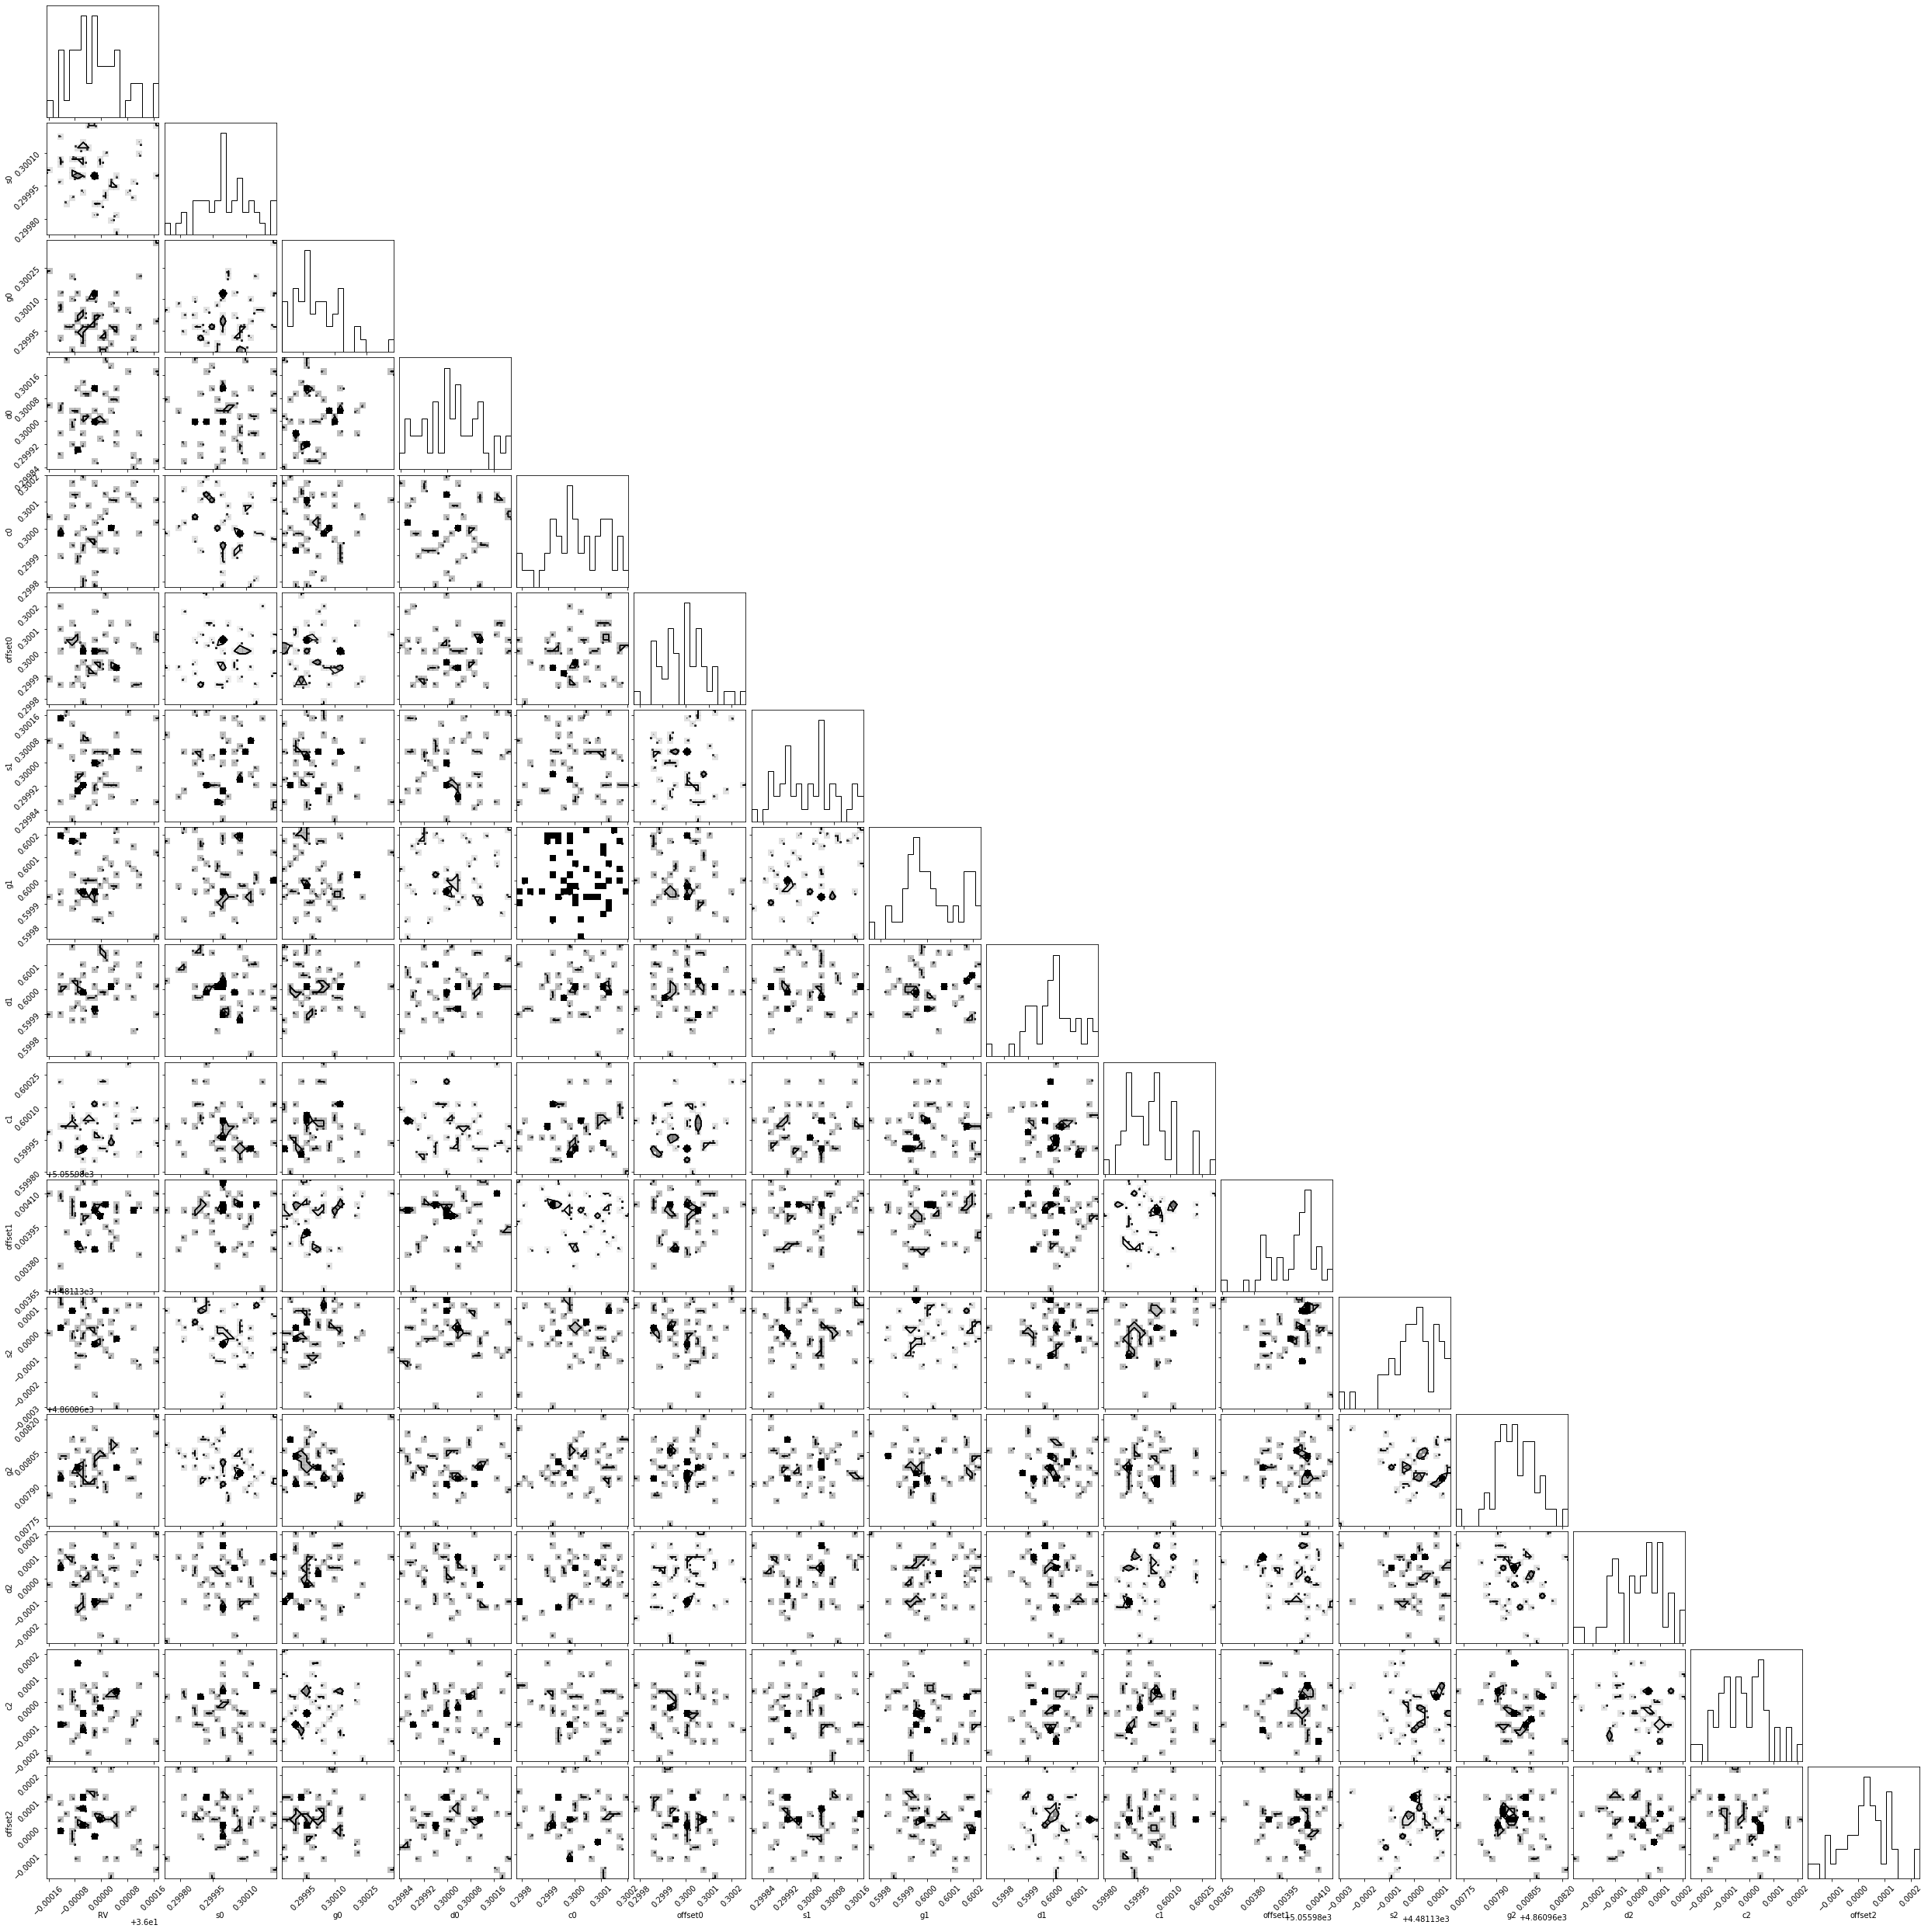

In [10]:
#Plotting corner plot for trial model

#with plt.rc_context(default_settings):
#plt.rcParams.update(default_settings)
paramnames = [[('RV', r'\Delta')]] + [[(f's{i}', f's_{i}'), (f'g{i}', f'g_{i}'),(f'd{i}',f'd_{i}'),(f'c{i}',f'c_{i}'),(f'offset{i}',f'offset_{i}')] for i in range(n)] 
paramnames = [item for sublist in paramnames for item in sublist]

# Get the samples
samples = sampler.get_chain(discard=100, thin=1, flat=False)
labels = [name_tuple[0] for name_tuple in paramnames]
# Plot the traces

#plotting all the variables

fig, axes = plt.subplots(len(labels), figsize=(10, 10), sharex=True)
#labels = ["rv","w1","d1","w2","d2","sigma"]
for i in range(len(labels)):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")
plt.show() 
""" 
fig, axes = plt.subplots(1, figsize=(10, 6), sharex=True)
axes.plot(samples[:, :, 0], "k", alpha=0.3)
axes.set_xlim(0, len(samples))
axes.set_ylabel("RV (km/s)")
axes.yaxis.set_label_coords(-0.1, 0.5)
axes.set_xlabel("step number")
plt.show() """

# Flatten the samples
flat_samples = sampler.get_chain(discard=0, thin=15, flat=True)
percentiles = np.percentile(flat_samples, [16, 50, 84], axis=0)  # This gives the 16th, 50th (median), and 84th percentiles


print(percentiles)
# Compute the medians of the parameter samples
#variables = percentiles[1]
variables = np.median(flat_samples, axis=0)

print(variables)


fig = corner.corner(
    flat_samples, labels=labels,truths=[variables])

# Annotate variables on the plot
for i, var_value in enumerate(variables.items()):
    plt.annotate(f" {var_value:.5f}", xy=(-1, 4.5 - i * 0.5), xycoords='axes fraction', fontsize=20, ha='left')




In [ ]:
print(b_lines)

In [ ]:
#Another attempt at making a simpler initialization of the model, where I label each parameter individually

#importing, cropping, and normalising data
wav,flux,t,star = Get_Wavelength_Flux_File("/data/wdplanetary/omri/Data/WD1929+012/2017-1-SCI-031.20170714/product/mbgphH201707140017_u2wm.fits")
#rwav,rflux,t,star = Get_Wavelength_Flux_File("/data/wdplanetary/omri/Data/WD1929+012/2017-1-SCI-031.20170711/product/mbgphR201707110020_u2wm.fits")
#wav = np.concatenate((bwav,rwav))
#flux = np.concatenate((bflux,rflux))
#lower bound of window
u_loc = np.searchsorted(wav, 5200) #5200
closest_value = wav[max(0, u_loc-1)]
u_bound = np.where(wav == closest_value)
u_bound = int(u_bound[0])
#find the lower bound of the window
l_loc = np.searchsorted(wav, 4100) #4100
closest_value = wav[max(0, l_loc-1)]
l_bound = np.where(wav == closest_value)
l_bound = int(l_bound[0])
y = flux[l_bound:u_bound]
l = wav[l_bound:u_bound]
p_result = poly_fit(l,y)
D = y/p_result
sigma = calculate_error(D)/2


lines = ([i[1] for i in b_lines])

#initializing values

rv = 36

#First profile - Mg 4481 - initial values
ci_4481 = 4481.185
si_4481 = 0.3
gi_4481 = 0.3
di_4481 = 0.5
oi_4481 = 0

#Second profile - H 4860
ci_4860 = 4860.986
si_4860 = 1.4
gi_4860 = 1.4
di_4860 = 2
oi_4860 = -0.05

#Third profile - Si 5055
ci_5055 = 5055.984
si_5055 = 0.3
gi_5055 = 0.3
di_5055 = 0.5
oi_5055 = 0

#Vague general limits on the fits - 
smax = 20
smin = 0.00001
gmax = 20
gmin = 0.00001
dmin = 0.0001
dmax = 10
omax = 0.1
omin = -0.1
rvmax = 60
rvmin = 0


n = 3 #number of lines 
theta = [rv, ci_4481, si_4481, gi_4481,di_4481 ,oi_4481, ci_4860, si_4860, gi_4860, di_4860, oi_4860, ci_5055, si_5055, gi_5055, di_5055, oi_5055]  

#initilizing values
#priors for the values
#gaussian profile for line centre with the x as a function

#first attempt to make gaussian priors, now doing inside the logprior function
""" 
for j in c1:
    gaussian = (norm.pdf(D, j, 0.04)) #make a prior function for the line 
    plt.plot(D,gaussian)
    plt.show()
    sum = np.sum(gaussian)
    c_priors_list.append(sum)
 """




def f(l, theta):
    #function to generate the model
    #model = 1
    model = np.ones_like(D)
    model += theta[5] -  theta[4] * voigt_profile( (l-(theta[1]*(1+(theta[0])/299792.0)))  ,theta[2], theta[3])
    model += theta[10] - theta[9] * voigt_profile( (l-(theta[6]*(1+(theta[0])/299792.0)))  ,theta[7], theta[8])
    model += theta[15] - theta[14]* voigt_profile( (l-(theta[11]*(1+(theta[0])/299792.0)))  ,theta[12], theta[13])

    return model

#test plot to see how the model looks like compared to the spectrum 
for i in lines:
    plt.plot(l, f(l,theta))
    plt.plot(l,D)
    plt.fill_between(l,f(l,theta) - sigma, f(l,theta) + sigma, color='gray', alpha=0.3)
    plt.xlim(i -20,i +20)
    plt.ylim(0.4,1.6)
    plt.show()
    

def log_likelihood(theta, l, D,sigma):
    residual = D - f(l, theta)
    return -0.5 * np.sum((residual / sigma)**2 + np.log(2 * np.pi * sigma**2))

# Define the log prior function
def log_prior(theta):
    total_log_prior = 0
    
    #setting the logprior to False if outside the priors
    if not (rvmin < theta[0] < rvmax):
        return -np.inf
    
    if not (smin < theta[2] < smax) or not (smin < theta[7] < smax) or not (smin < theta[12] < smax):
            return -np.inf
    
    if not (gmin < theta[3] < gmax) or  not (gmin < theta[8] < gmax) or  not (gmin < theta[13] < gmax):
            return -np.inf
    
    if not (dmin < theta[4] < dmax) or not (dmin < theta[9] < dmax) or  not (dmin < theta[14] < dmax):
            return -np.inf
    
    if not (omin < theta[5] < omax) or  not (omin < theta[10] < omax) or   not (omin < theta[15] < omax):
            return -np.inf
    
    if not ((ci_4481 - 0.1) < theta[1] < (ci_4481 + 0.1)) or not ((ci_4860 - 0.1) < theta[6] < (ci_4860 + 0.1)) or not ((ci_4481 - 0.1) < theta[11] < (ci_4481 +0.1)):
         return -np.inf
     
    c4481_prior_logpdf = np.sum(norm.logpdf(theta[1], loc = ci_4481,scale = 0.001))
    c4860_prior_logpdf = np.sum(norm.logpdf(theta[6], loc = ci_4860,scale = 0.001))
    c5055_prior_logpdf = np.sum(norm.logpdf(theta[11], loc = ci_5055,scale = 0.001))
    total_log_prior += c4481_prior_logpdf + c4860_prior_logpdf + c5055_prior_logpdf
    
        #restricting for bounds on parameters
        
    #adding a logprior function
    
    #prior_mu = norm.logpdf(theta[0], loc=0, scale=1)
    
    return total_log_prior

# Define the log posterior function
def log_probability(theta, l, D,sigma):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, l, D,sigma)



# Initialize walker positions using Latin hypercube sampling - also works - different way to initialize the sampling
""" 
from pyDOE import lhs
nwalkers = 64
ndim = len(theta)  # Assuming n is defined elsewhere
bounds = np.array([prior_min, prior_max]).T  # Define bounds for each parameter
lhs_samples = lhs(ndim, samples=nwalkers)
data = pd.DataFrame(lhs_samples)
pos = bounds[:, 0] + lhs_samples * (bounds[:, 1] - bounds[:, 0])
 """

 
#initialise walkers and pos using normal gaussian distributions
pos = (theta) + 1e-2 * np.random.randn(3*len(theta), len(theta))
nwalkers, ndim = pos.shape 



# Run the sampler
with Pool() as pool:

    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(l,D,sigma),pool = pool)
    sampler.run_mcmc(pos, nsteps, progress=True)
    


In [ ]:
paramnames = [[('RV', r'\Delta')]] + [[(f'c{i}',f'c_{i}'),(f's{i}', f's_{i}'), (f'g{i}', f'g_{i}'),(f'd{i}',f'd_{i}'),(f'offset{i}',f'offset_{i}')] for i in range(n)] 
paramnames = [item for sublist in paramnames for item in sublist]

# Get the samples
samples = sampler.get_chain(discard=100, thin=1, flat=False)
labels = [name_tuple[0] for name_tuple in paramnames]
# Plot the traces

#plotting all the variables

fig, axes = plt.subplots(len(labels), figsize=(10, 10), sharex=True)
#labels = ["rv","w1","d1","w2","d2","sigma"]
for i in range(len(labels)):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")
plt.show() 
""" 
fig, axes = plt.subplots(1, figsize=(10, 6), sharex=True)
axes.plot(samples[:, :, 0], "k", alpha=0.3)
axes.set_xlim(0, len(samples))
axes.set_ylabel("RV (km/s)")
axes.yaxis.set_label_coords(-0.1, 0.5)
axes.set_xlabel("step number")
plt.show() """

# Flatten the samples
flat_samples = sampler.get_chain(discard=0, thin=15, flat=True)
percentiles = np.percentile(flat_samples, [16, 50, 84], axis=0)  # This gives the 16th, 50th (median), and 84th percentiles


print(percentiles)
# Compute the medians of the parameter samples
#variables = percentiles[1]
variables = np.median(flat_samples, axis=0)

print(variables)


fig = corner.corner(
    flat_samples, labels=labels,truths=[variables])

# Annotate variables on the plot
for i, var_value in enumerate(variables.items()):
    plt.annotate(f" {var_value:.5f}", xy=(-1, 4.5 - i * 0.5), xycoords='axes fraction', fontsize=20, ha='left')



In [ ]:
print(r_lines)

The reference pixel in timefile: 2017-07-14T21:38:23.304 is 1.0
<Parameter 'c0', value=-474548.344031728 +/- 127, bounds=[-inf:inf]> <Parameter 'c1', value=712.5222533502528 +/- 0.132, bounds=[-inf:inf]> <Parameter 'c2', value=-0.4579587920489541 +/- 4.36e-05, bounds=[-inf:inf]> <Parameter 'c3', value=0.0001633322326876904 +/- nan, bounds=[-inf:inf]> <Parameter 'c4', value=-3.491098809906462e-08 +/- nan, bounds=[-inf:inf]>


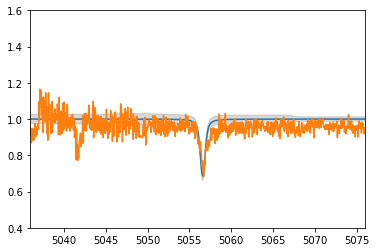

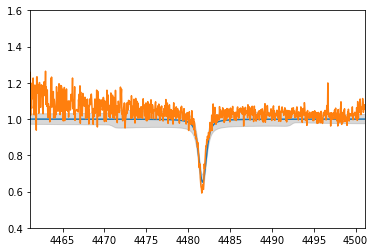

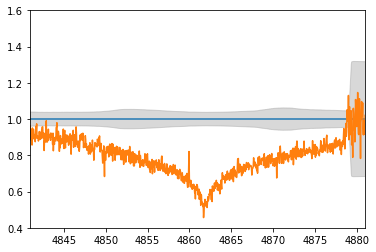

ModuleNotFoundError: No module named 'pyDOE'

In [11]:
#Another attempt, two lines - no central variance of the lines - this is working!!

#importing, cropping, and normalising data
wav,flux,t,star = Get_Wavelength_Flux_File("/data/wdplanetary/omri/Data/WD1929+012/2017-1-SCI-031.20170714/product/mbgphH201707140017_u2wm.fits")
#rwav,rflux,rt,rstar = Get_Wavelength_Flux_File("/data/wdplanetary/omri/Data/WD1929+012/2017-1-SCI-031.20170711/product/mbgphR201707110020_u2wm.fits")
#wav = np.concatenate((bwav,rwav))
#flux = np.concatenate((bflux,rflux))
#lower bound of window
u_loc = np.searchsorted(wav, 5200) #5200
closest_value = wav[max(0, u_loc-1)]
u_bound = np.where(wav == closest_value)
u_bound = int(u_bound[0])
#find the lower bound of the window
l_loc = np.searchsorted(wav, 4100) #4100
closest_value = wav[max(0, l_loc-1)]
l_bound = np.where(wav == closest_value)
l_bound = int(l_bound[0])
y = flux[l_bound:u_bound]
l = wav[l_bound:u_bound]
p_result = poly_fit(l,y)
D = y/p_result
sigma = calculate_error(D)/2


lines = ([i[1] for i in b_lines])

#initializing values

rv = 36

#First profile - Mg 4481 - initial values
ci_4481 = 4481.185
si_4481 = 0.3
gi_4481 = 0.3
di_4481 = 0.5
oi_4481 = 0


#Third profile - Si 5055
ci_5055 = 5055.984
si_5055 = 0.2
gi_5055 = 0.2
di_5055 = 0.3
oi_5055 = 0

#Vague general limits on the fits - 
#for absorption lines
smax = 1
smin = 0.00001
gmax = 1
gmin = 0.00001

#for H lines
hsmax = 20
hsmin = 0.0001
hgmax = 20
hgmin = 0.0001

dmin = 0.0001
dmax = 1
omax = 0.1
omin = -0.1
rvmax = 60
rvmin = 0


n = 2 #number of lines 
theta = [rv, si_4481, gi_4481,di_4481 ,oi_4481, si_5055, gi_5055, di_5055, oi_5055]  

#initilizing values
#priors for the values
#gaussian profile for line centre with the x as a function

#first attempt to make gaussian priors, now doing inside the logprior function
""" 
for j in c1:
    gaussian = (norm.pdf(D, j, 0.04)) #make a prior function for the line 
    plt.plot(D,gaussian)
    plt.show()
    sum = np.sum(gaussian)
    c_priors_list.append(sum)
 """




def f(l, theta):
    #function to generate the model
    #model = 1
    model = np.ones_like(D)
    # offset - depth * Voigt profile(centre, sigma, gamma) 
    #With centre RV shifted 
    model += theta[4] -  theta[3] * voigt_profile( (l-(ci_4481*(1+(theta[0])/299792.0)))  ,theta[1], theta[2])
    model += theta[8] - theta[7] * voigt_profile( (l-(ci_5055*(1+(theta[0])/299792.0)))  ,theta[5], theta[6])
    #model += theta[12] - theta[11]* voigt_profile( (l-(ci_5055*(1+(theta[0])/299792.0)))  ,theta[9], theta[10]) if you add another line it goes here

    return model

#test plot to see how the model looks like compared to the spectrum 
for i in lines:
    plt.plot(l, f(l,theta))
    plt.plot(l,D)
    plt.fill_between(l,f(l,theta) - sigma, f(l,theta) + sigma, color='gray', alpha=0.3)
    plt.xlim(i -20,i +20)
    plt.ylim(0.4,1.6)
    plt.show()
    

def log_likelihood(theta, l, D):
    residual = D - f(l, theta)
    return -0.5 * np.sum((residual / sigma)**2 + np.log(2 * np.pi * sigma**2))

# Define the log prior function
def log_prior(theta):
    total_log_prior = 0
    
    #setting the logprior to False if outside the priors
    if not (rvmin < theta[0] < rvmax):
        return -np.inf
    
    if not (smin < theta[1] < smax) or not (smin < theta[5] < smax): #or not (smin < theta[9] < smax):
            return -np.inf
    
    if not (gmin < theta[2] < gmax) or  not (gmin < theta[6] < gmax): # or  not (gmin < theta[10] < gmax):
            return -np.inf
    
    if not (dmin < theta[3] < dmax) or not (dmin < theta[7] < dmax): # or  not (dmin < theta[11] < dmax):
            return -np.inf
    
    if not (omin < theta[4] < omax) or  not (omin < theta[8] < omax): # or  not (omin < theta[12] < omax):
            return -np.inf
    """
    if not ((ci_4481 - 0.1) < theta[1] < (ci_4481 + 0.1)) or not ((ci_4860 - 0.1) < theta[6] < (ci_4860 + 0.1)) or not ((ci_4481 - 0.1) < theta[11] < (ci_4481 +0.1)):
         return -np.inf
    
    c4481_prior_logpdf = np.sum(norm.logpdf(theta[1], loc = ci_4481,scale = 0.04))
    c4860_prior_logpdf = np.sum(norm.logpdf(theta[6], loc = ci_4860,scale = 0.04))
    c5055_prior_logpdf = np.sum(norm.logpdf(theta[11], loc = ci_5055,scale = 0.04))
    total_log_prior += c4481_prior_logpdf + c4860_prior_logpdf + c5055_prior_logpdf
    """
    #restricting for bounds on parameters
        
    #adding a logprior function
    
    #prior_mu = norm.logpdf(theta[0], loc=0, scale=1)
    
    return total_log_prior

# Define the log posterior function
def log_probability(theta, l, D):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, l, D)



# Initialize walker positions using Latin hypercube sampling - also works - different way to initialize the sampling
prior_min = np.array([rvmin] + [smin,gmin, dmin, omin]*n ) 
prior_max = np.array([rvmax] + [smax,gmax, dmax, omax]*n ) 


from pyDOE import lhs
nwalkers = 3* len(theta)
ndim = len(theta)  # Assuming n is defined elsewhere
bounds = np.array([prior_min, prior_max]).T  # Define bounds for each parameter
lhs_samples = lhs(ndim, samples=nwalkers)
data = pd.DataFrame(lhs_samples)
pos = bounds[:, 0] + lhs_samples * (bounds[:, 1] - bounds[:, 0])
print(pos.shape)


 
#initialise walkers and pos using normal gaussian distributions
""" 
pos = (theta) + 1e-2 * np.random.randn(2*len(theta), len(theta))
nwalkers, ndim = pos.shape 
print(pos.shape)
 """

# Run the sampler
nsteps = 5000
with Pool() as pool:

    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(l,D),pool = pool)
    sampler.run_mcmc(pos, nsteps, progress=True)
    
flat_samples = sampler.get_chain(discard=2000, thin=1, flat=True)
percentiles = np.percentile(flat_samples, [16, 50, 84], axis=0)  # This gives the 16th, 50th (median), and 84th percentiles
print(percentiles)
rv_lerr = percentiles[0,0]
rv = percentiles[1,0]
rv_herr = percentiles[2,0]
print(rv_lerr,rv,rv_herr)



ValueError: Image size of 265980x1032 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 800x1200 with 1 Axes>

/data/wdplanetary/omri/envs/omrienv/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
/data/wdplanetary/omri/envs/omrienv/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
/data/wdplanetary/omri/envs/omrienv/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
/data/wdplanetary/omri/envs/omrienv/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
/data/wdplanetary/omri/envs/omrienv/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: Attempting to set identical left == right == 0 re

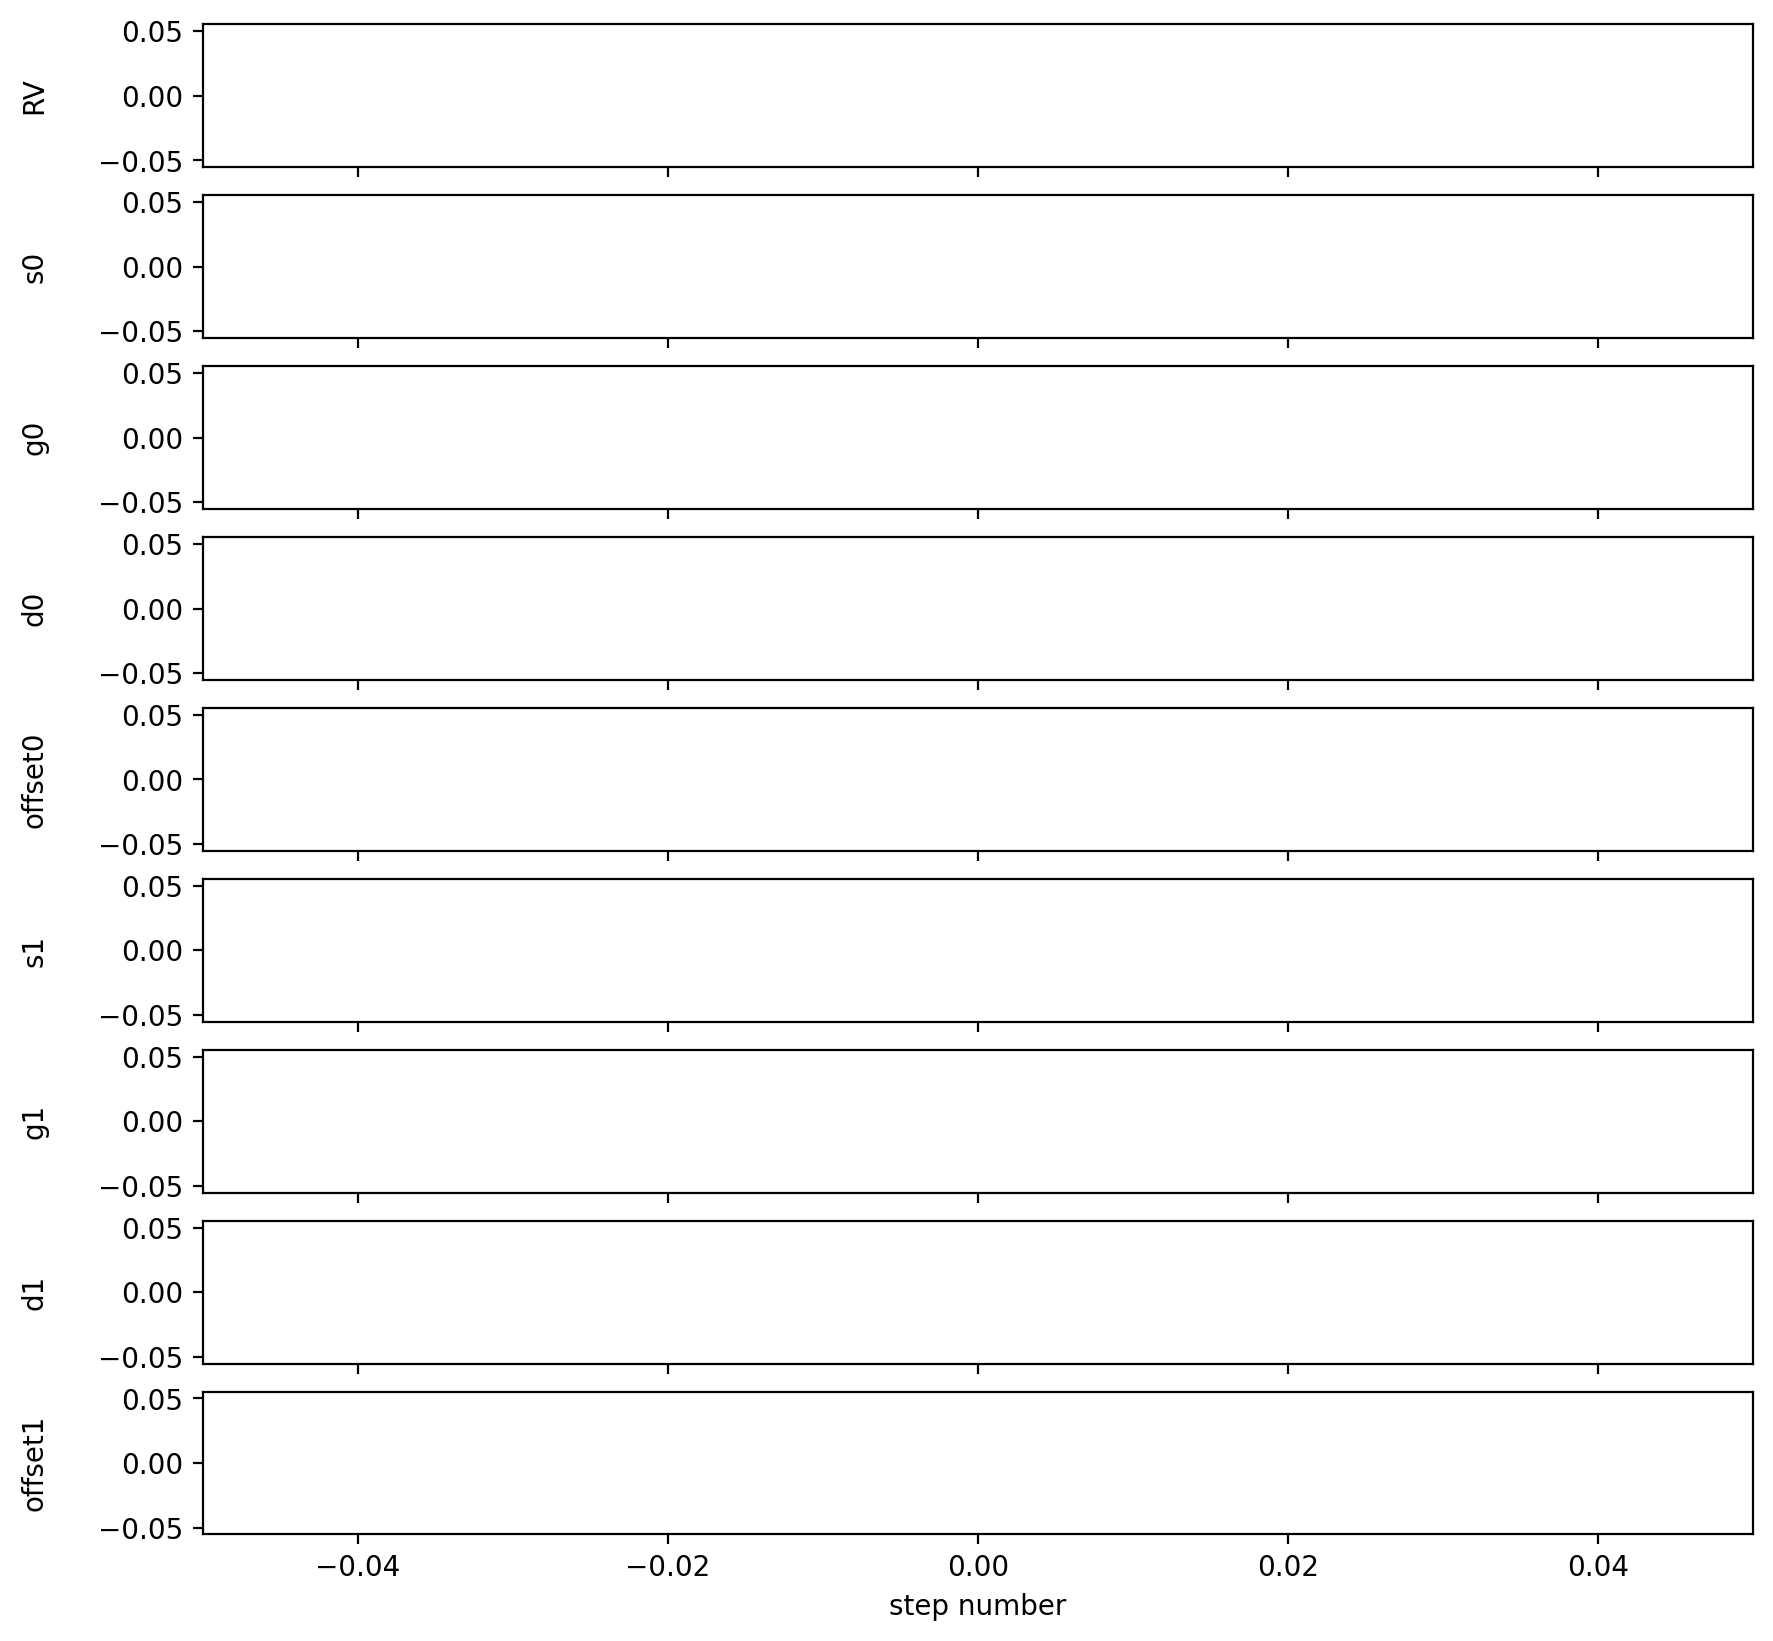

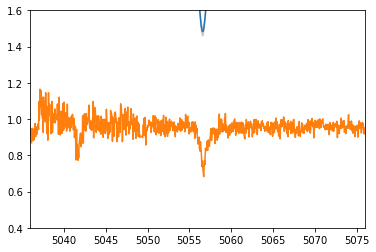

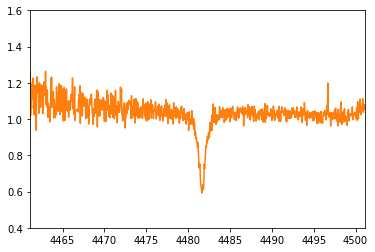

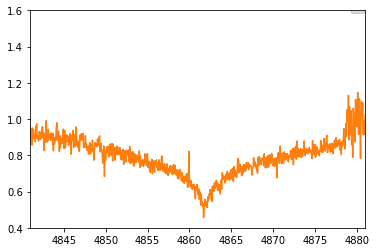

In [12]:
rv_samples = flat_samples[:, 0]
rvp = np.percentile(rv_samples, [16, 50, 84])
# Plot the probability density function (PDF) of the RV parameter
plt.figure(figsize=(4, 6),dpi = 200)
plt.hist(rv_samples, bins=30, density=True, color='skyblue', alpha=0.7)
for percentile in rvp:
    plt.axvline(percentile, color='red', linestyle='--', linewidth=1)
    plt.text(percentile - 0.16, 0.3, f'{percentile:.2f}', rotation=90, verticalalignment='bottom', horizontalalignment='center', color='red')

plt.xlabel('RV (km/s)')
plt.ylabel('Probability Density')
#plt.title('Probability Density Function (PDF) of RV Parameter')
plt.show()


paramnames = [[('RV', r'\Delta')]] + [[(f's{i}', f's_{i}'), (f'g{i}', f'g_{i}'),(f'd{i}',f'd_{i}'),(f'offset{i}',f'offset_{i}')] for i in range(n)] 
paramnames = [item for sublist in paramnames for item in sublist]

# Get the samples
samples = sampler.get_chain(discard=2000, thin=1, flat=False)
labels = [name_tuple[0] for name_tuple in paramnames]
# Plot the traces

#plotting all the variables

fig, axes = plt.subplots(len(labels), figsize=(10, 10), sharex=True,dpi = 200)
#labels = ["rv","w1","d1","w2","d2","sigma"]
for i in range(len(labels)):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")
plt.show() 
""" 
fig, axes = plt.subplots(1, figsize=(10, 6), sharex=True)
axes.plot(samples[:, :, 0], "k", alpha=0.3)
axes.set_xlim(0, len(samples))
axes.set_ylabel("RV (km/s)")
axes.yaxis.set_label_coords(-0.1, 0.5)
axes.set_xlabel("step number")
plt.show() """

# Flatten the samples

# Compute the medians of the parameter samples
#variables = percentiles[1]
variables = np.median(flat_samples, axis=0)

for i in lines:
    plt.plot(l, f(l,variables))
    plt.plot(l,D)
    plt.fill_between(l,f(l,variables) - sigma, f(l,variables) + sigma, color='gray', alpha=0.3)
    plt.xlim(i -20,i +20)
    plt.ylim(0.4,1.6)
    plt.show()

#fig = corner.corner(flat_samples, labels=labels,truths=[variables],dpi = 300)

# Annotate variables on the plot
#for i, var_value in enumerate(variables.items()):
#    plt.annotate(f" {var_value:.5f}", xy=(-1, 4.5 - i * 0.5), xycoords='axes fraction', fontsize=20, ha='left')



In [ ]:
#Another attempt, two lines - no central variance of the lines - attempting to get a prior on central value of line now
#Working - iterating for everything


rvs = []
rvs_ul = []
rvs_ll = []
time_strings = []
star = "WD1929"
n = 0
length = len(b_files)

for num,i in enumerate(b_files):
#importing, cropping, and normalising data
    wav,flux,t,obj = Get_Wavelength_Flux_File(i)
    if obj.startswith(star):
        #"/data/wdplanetary/omri/Data/WD1929+012/2017-1-SCI-031.20170714/product/mbgphH201707140017_u2wm.fits"
        #rwav,rflux,rt,rstar = Get_Wavelength_Flux_File("/data/wdplanetary/omri/Data/WD1929+012/2017-1-SCI-031.20170711/product/mbgphR201707110020_u2wm.fits")
        #wav = np.concatenate((bwav,rwav))
        #flux = np.concatenate((bflux,rflux))
        #lower bound of window
        u_loc = np.searchsorted(wav, 5200) #5200
        closest_value = wav[max(0, u_loc-1)]
        u_bound = np.where(wav == closest_value)
        u_bound = int(u_bound[0])
        #find the lower bound of the window
        l_loc = np.searchsorted(wav, 4100) #4100
        closest_value = wav[max(0, l_loc-1)]
        l_bound = np.where(wav == closest_value)
        l_bound = int(l_bound[0])
        y = flux[l_bound:u_bound]
        l = wav[l_bound:u_bound]
        p_result = poly_fit(l,y)
        D = y/p_result
        sigma = calculate_error(D)/2


        lines = ([i[1] for i in b_lines])

        #initializing values

        rv = 36

        #First profile - Mg 4481 - initial values
        ci_4481 = 4481.185
        si_4481 = 0.3
        gi_4481 = 0.3
        di_4481 = 0.5
        oi_4481 = 0


        #Second profile - Si 5055
        ci_5055 = 5055.984
        si_5055 = 0.2
        gi_5055 = 0.2
        di_5055 = 0.3
        oi_5055 = 0

        #Vague general limits on the fits - 
        #for absorption lines
        smax = 1
        smin = 0.00001
        gmax = 1
        gmin = 0.00001

        #for H lines
        hsmax = 20
        hsmin = 0.0001
        hgmax = 20
        hgmin = 0.0001

        dmin = 0.0001
        dmax = 1
        omax = 0.01
        omin = -0.01
        rvmax = 60
        rvmin = 0


        n = 2 #number of lines 
        theta = [rv, ci_4481,si_4481, gi_4481,di_4481 ,oi_4481,ci_5055, si_5055, gi_5055, di_5055, oi_5055]  

        #initilizing values
        #priors for the values
        #gaussian profile for line centre with the x as a function

        #first attempt to make gaussian priors, now doing inside the logprior function
        """ 
        for j in c1:
            gaussian = (norm.pdf(D, j, 0.04)) #make a prior function for the line 
            plt.plot(D,gaussian)
            plt.show()
            sum = np.sum(gaussian)
            c_priors_list.append(sum)
        """




        def f(l, theta):
            #function to generate the model
            #model = 1
            model = np.ones_like(D)
            # offset - depth * Voigt profile(centre, sigma, gamma) 
            #With centre RV shifted 
            model += theta[5] -  theta[4] * voigt_profile( (l-(theta[1]*(1+(theta[0])/299792.0)))  ,theta[2], theta[3])
            model += theta[10] - theta[9] * voigt_profile( (l-(theta[6]*(1+(theta[0])/299792.0)))  ,theta[7], theta[8])
            #model += theta[12] - theta[11]* voigt_profile( (l-(ci_5055*(1+(theta[0])/299792.0)))  ,theta[9], theta[10]) if you add another line it goes here

            return model
        
        #test plot to see how the model looks like compared to the spectrum 
        for i in lines:
            plt.plot(l, f(l,theta))
            plt.plot(l,D)
            plt.fill_between(l,f(l,theta) - sigma, f(l,theta) + sigma, color='gray', alpha=0.3)
            plt.xlim(i -20,i +20)
            plt.ylim(0.4,1.6)
            plt.show()
         

        def log_likelihood(theta, l, D):
            residual = D - f(l, theta)
            return -0.5 * np.sum((residual / sigma)**2 + np.log(2 * np.pi * sigma**2))

        # Define the log prior function
        def log_prior(l,theta):
            total_log_prior = 0
            
            #setting the logprior to False if outside the priors
            if not (rvmin < theta[0] < rvmax):
                return -np.inf
            
            if not (smin < theta[2] < smax) or not (smin < theta[7] < smax): #or not (smin < theta[9] < smax):
                    return -np.inf
            
            if not (gmin < theta[3] < gmax) or  not (gmin < theta[8] < gmax): # or  not (gmin < theta[10] < gmax):
                    return -np.inf
            
            if not (dmin < theta[4] < dmax) or not (dmin < theta[9] < dmax): # or  not (dmin < theta[11] < dmax):
                    return -np.inf
            
            if not (omin < theta[5] < omax) or  not (omin < theta[10] < omax): # or  not (omin < theta[12] < omax):
                    return -np.inf
            
            if not ((4481.15) < theta[1] < (4481.22)) or not ((5055.93) < theta[6] < (5056.08)): #or not ((ci_4481 - 0.1) < theta[11] < (ci_4481 +0.1)):
                return -np.inf
            """
            c4481_prior_logpdf = np.sum(norm.logpdf(theta[1], loc = ci_4481,scale = 0.04))
            c4860_prior_logpdf = np.sum(norm.logpdf(theta[6], loc = ci_4860,scale = 0.04))
            c5055_prior_logpdf = np.sum(norm.logpdf(theta[11], loc = ci_5055,scale = 0.04))
            total_log_prior += c4481_prior_logpdf + c4860_prior_logpdf + c5055_prior_logpdf
            """
            #restricting for bounds on parameters
                
            #adding a logprior function
            
            #prior_mu = norm.logpdf(theta[0], loc=0, scale=1)
            
            return total_log_prior

        # Define the log posterior function
        def log_probability(theta, l, D):
            lp = log_prior(l,theta)
            if not np.isfinite(lp):
                return -np.inf
            return lp + log_likelihood(theta, l, D)



        # Initialize walker positions using Latin hypercube sampling - also works - different way to initialize the sampling
        prior_min = np.array([rvmin] + [4481.1,smin,gmin, dmin, omin] + [5055.98,smin,gmin, dmin, omin]) 
        prior_max = np.array([rvmax] + [4481.2, smax,gmax, dmax, omax] + [5056.03, smax,gmax, dmax, omax]) 


        from pyDOE import lhs
        nwalkers = 3* len(theta)
        ndim = len(theta)  # Assuming n is defined elsewhere
        bounds = np.array([prior_min, prior_max]).T  # Define bounds for each parameter
        lhs_samples = lhs(ndim, samples=nwalkers)
        data = pd.DataFrame(lhs_samples)
        pos = bounds[:, 0] + lhs_samples * (bounds[:, 1] - bounds[:, 0])
        print(pos.shape)


        
        #initialise walkers and pos using normal gaussian distributions
        """ 
        pos = (theta) + 1e-2 * np.random.randn(2*len(theta), len(theta))
        nwalkers, ndim = pos.shape 
        print(pos.shape)
        """
        print(f"{num} / {length} spectra")
        # Run the sampler
        nsteps = 5000
        with Pool() as pool:

            sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(l,D),pool = pool)
            sampler.run_mcmc(pos, nsteps, progress=True)

        flat_samples = sampler.get_chain(discard=2000, thin=1, flat=True)
        percentiles = np.percentile(flat_samples, [16, 50, 84], axis=0)  # This gives the 16th, 50th (median), and 84th percentiles
        print(percentiles)
        rv_lerr = percentiles[0,0]
        rv = percentiles[1,0]
        rv_herr = percentiles[2,0]
        #print(rv_lerr,rv,rv_herr)

        rv_samples = flat_samples[:, 0]
        rvp = np.percentile(rv_samples, [16, 50, 84])
        # Plot the probability density function (PDF) of the RV parameter
        plt.figure(figsize=(4, 6),dpi = 200)
        plt.hist(rv_samples, bins=30, density=True, color='skyblue', alpha=0.7)
        for percentile in rvp:
            plt.axvline(percentile, color='red', linestyle='--', linewidth=1)
            plt.text(percentile - 0.16, 0.3, f'{percentile:.2f}', rotation=90, verticalalignment='bottom', horizontalalignment='center', color='red')

        plt.xlabel('RV (km/s)')
        plt.ylabel('Probability Density')
        #plt.title('Probability Density Function (PDF) of RV Parameter')
        plt.show()

        rvs.append((rv)) #-rv_corr
        rvs_ul.append((rv_herr)) 
        rvs_ll.append((rv_lerr))
        time_strings.append((t))
    else:
        print("This is a file for " + str(obj) + " instead of " + str(star))
        continue

In [ ]:
#Combining data points that are the same times
t_list = Time(time_strings, scale='utc')
times = t_list.datetime 
t0 = times[0]
tseconds = np.array([(dt - t0).total_seconds() for dt in times])
tdays = tseconds * 1/(24*3600)
mean = np.nanmean(rvs)
print(mean)


tarray = np.array(tdays)
rvarray = np.array(rvs)
rvuerrsarray = np.array(rvs_ul)
rvlerrsarray = np.array(rvs_ll)
#rverrsarray = np.array(rverrs)
#rvcorrsarray = np.array(rv_corrs)
#rverrsarray = np.full(len(tarray),2)

filtered_indices = np.where(( rvarray > 34 ) & ( rvarray < 38 ))[0] #& (rvarray > 10)
filtered_rvarray = rvarray[filtered_indices]
filtered_tarray = tarray[filtered_indices]
filtered_rvuerrsarray = rvuerrsarray[filtered_indices]
filtered_rvlerrsarray = rvlerrsarray[filtered_indices]
#filtered_rvcorrsarray = rvcorrsarray[filtered_indices]

filtered_mean = np.nanmean(filtered_rvarray)
print(filtered_mean)
unique_times = np.unique(filtered_tarray)
averages_unfiltered = np.array([tarray, rvarray, rvlerrsarray,rvuerrsarray])

averages = np.array([[t, np.nanmean(filtered_rvarray[filtered_tarray == t]), np.nanmean(filtered_rvlerrsarray[filtered_tarray == t]),np.nanmean(filtered_rvuerrsarray[filtered_tarray == t])] for t in unique_times])
#averages = averages[np.isnan(averages[:,1])]
#averages = np.array([times,rvarray,rvlerrsarray,rvuerrsarray])
print(averages)#

np.savetxt("/data/wdplanetary/omri/Output/resultfiles/bayesian/first_try_two_lines.txt",averages)

In [ ]:
paramnames = [[('RV', r'\Delta')]] + [[(f'c{i}', f'c_{i}'), (f's{i}', f's_{i}'), (f'g{i}', f'g_{i}'),(f'd{i}',f'd_{i}'),(f'offset{i}',f'offset_{i}')] for i in range(n)] 
paramnames = [item for sublist in paramnames for item in sublist]

# Get the samples
samples = sampler.get_chain(discard=2000, thin=1, flat=False)
labels = [name_tuple[0] for name_tuple in paramnames]
# Plot the traces

#plotting all the variables

fig, axes = plt.subplots(len(labels), figsize=(10, 10), sharex=True)
#labels = ["rv","w1","d1","w2","d2","sigma"]
for i in range(len(labels)):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")
plt.show() 
""" 
fig, axes = plt.subplots(1, figsize=(10, 6), sharex=True)
axes.plot(samples[:, :, 0], "k", alpha=0.3)
axes.set_xlim(0, len(samples))
axes.set_ylabel("RV (km/s)")
axes.yaxis.set_label_coords(-0.1, 0.5)
axes.set_xlabel("step number")
plt.show() """

# Flatten the samples

# Compute the medians of the parameter samples
#variables = percentiles[1]
variables = np.median(flat_samples, axis=0)

for i in lines:
    plt.plot(l, f(l,variables))
    plt.plot(l,D)
    plt.fill_between(l,f(l,variables) - sigma, f(l,variables) + sigma, color='gray', alpha=0.3)
    plt.xlim(i -20,i +20)
    plt.ylim(0.4,1.6)
    plt.show()

fig = corner.corner(flat_samples, labels=labels,truths=[variables])

# Annotate variables on the plot
for i, var_value in enumerate(variables.items()):
    plt.annotate(f" {var_value:.5f}", xy=(-1, 4.5 - i * 0.5), xycoords='axes fraction', fontsize=20, ha='left')


In [ ]:
#AAttempt with all the abs lines - crazy amount of parameters
from multiprocessing import Pool
#importing, cropping, and normalising data
bwav,bflux,t,star = Get_Wavelength_Flux_File("/data/wdplanetary/omri/Data/WD1929+012/2017-1-SCI-031.20170714/product/mbgphH201707140017_u2wm.fits")
rwav,rflux,rt,rstar = Get_Wavelength_Flux_File("/data/wdplanetary/omri/Data/WD1929+012/2017-1-SCI-031.20170711/product/mbgphR201707110020_u2wm.fits")
wav = np.concatenate((bwav,rwav))
flux = np.concatenate((bflux,rflux))
#lower bound of window
u_loc = np.searchsorted(wav, 7000) #5200
closest_value = wav[max(0, u_loc-1)]
u_bound = np.where(wav == closest_value)
u_bound = int(u_bound[0])
#find the lower bound of the window
l_loc = np.searchsorted(wav, 4100) #4100
closest_value = wav[max(0, l_loc-1)]
l_bound = np.where(wav == closest_value)
l_bound = int(l_bound[0])
y = flux[l_bound:u_bound]
l = wav[l_bound:u_bound]
p_result = poly_fit(l,y)
D = y/p_result
sigma = calculate_error(D)/2

blines = ([i[1] for i in b_lines])
rlines = ([i[1] for i in r_lines])
lines = blines + rlines
print(lines)
#initializing values

rv = 36

#First profile - Mg 4481 - initial values
ci_4481 = 4481.185
si_4481 = 0.3
gi_4481 = 0.3
di_4481 = 0.5
oi_4481 = 0

#Second profile - Si 5055
ci_5055 = 5055.984
si_5055 = 0.3
gi_5055 = 0.3
di_5055 = 0.5
oi_5055 = 0

ci_5957 = 5957.56
si_5957 = 0.3
gi_5957 = 0.3
di_5957 = 0.5
oi_5957 = 0

ci_5978 = 5978.93
si_5978 = 0.3
gi_5978 = 0.3
di_5978 = 0.5
oi_5978 = 0

ci_6347 = 6347.100
si_6347 = 0.3
gi_6347 = 0.3
di_6347 = 0.5
oi_6347 = 0

ci_6371 = 6371.360
si_6371 = 0.3
gi_6371 = 0.3
di_6371 = 0.5
oi_6371 = 0



#Vague general limits on the fits - 
#for absorption lines
smax = 1
smin = 0.00001
gmax = 1
gmin = 0.00001

#for H lines
hsmax = 20
hsmin = 0.0001
hgmax = 20
hgmin = 0.0001

dmin = 0.001
dmax = 1
omax = 0.1
omin = -0.1
rvmax = 60
rvmin = 0


n = 6 #number of lines 
theta = [rv, si_4481, gi_4481,di_4481 ,oi_4481, si_5055, gi_5055, di_5055, oi_5055,si_5957, gi_5957, di_5957, oi_5957,si_5978, gi_5978, di_5978, oi_5978, si_6347, gi_6347, di_6347, oi_6347,si_6371, gi_6371, di_6371, oi_6371 ]  

#initilizing values
#priors for the values
#gaussian profile for line centre with the x as a function

#first attempt to make gaussian priors, now doing inside the logprior function
""" 
for j in c1:
    gaussian = (norm.pdf(D, j, 0.04)) #make a prior function for the line 
    plt.plot(D,gaussian)
    plt.show()
    sum = np.sum(gaussian)
    c_priors_list.append(sum)
 """




def f(l, theta):
    #function to generate the model
    #model = 1
    model = np.ones_like(D)
    # offset - depth * Voigt profile(centre, sigma, gamma) 
    #With centre RV shifted 
    
    model += theta[4] -  theta[3] * voigt_profile( (l-(ci_4481*(1+(theta[0])/299792.0)))  ,theta[1], theta[2])
    model += theta[8] - theta[7] * voigt_profile( (l-(ci_5055*(1+(theta[0])/299792.0)))  ,theta[5], theta[6])
    model += theta[12] - theta[11]* voigt_profile( (l-(ci_5957*(1+(theta[0])/299792.0)))  ,theta[9], theta[10]) #if you add another line it goes here
    model += theta[16] - theta[15]* voigt_profile( (l-(ci_5978*(1+(theta[0])/299792.0)))  ,theta[13], theta[14])
    model += theta[20] - theta[19]* voigt_profile( (l-(ci_5978*(1+(theta[0])/299792.0)))  ,theta[17], theta[18])
    model += theta[24] - theta[23]* voigt_profile( (l-(ci_5978*(1+(theta[0])/299792.0)))  ,theta[21], theta[22])
    return model

#test plot to see how the model looks like compared to the spectrum 
for i in lines:
    plt.plot(l, f(l,theta))
    plt.plot(l,D)
    plt.fill_between(l,f(l,theta) - sigma, f(l,theta) + sigma, color='gray', alpha=0.3)
    plt.xlim(i -20,i +20)
    plt.ylim(0.4,1.6)
    plt.show()
    

def log_likelihood(theta, l, D):
    residual = D - f(l, theta)
    return -0.5 * np.sum((residual / sigma)**2 + np.log(2 * np.pi * sigma**2))

# Define the log prior function
def log_prior(theta):
    total_log_prior = 0
    
    #setting the logprior to False if outside the priors
    if not (rvmin < theta[0] < rvmax):
        return -np.inf
    
    if not (smin < theta[1] < smax) or not (smin < theta[5] < smax) or not (smin < theta[9] < smax) or not (smin < theta[13] < smax) or not (smin < theta[17] < smax) or not (smin < theta[21] < smax):
            return -np.inf
    
    if not (gmin < theta[2] < gmax) or not (gmin < theta[6] < gmax) or not (gmin < theta[10] < gmax) or not (gmin < theta[14] < gmax) or not (gmin < theta[18] < gmax) or not (gmin < theta[22] < gmax):
            return -np.inf
    
    if not (dmin < theta[3] < dmax) or not (dmin < theta[7] < dmax) or not (dmin < theta[11] < dmax) or not (dmin < theta[15] < dmax) or not (dmin < theta[19] < dmax) or not (dmin < theta[23] < dmax):
            return -np.inf
    
    if not (omin < theta[4] < omax) or not (omin < theta[8] < omax) or  not (omin < theta[12] < omax) or not (omin < theta[16] < omax) or not (omin < theta[20] < omax) or not (omin < theta[24] < omax):
            return -np.inf
    """
    if not ((ci_4481 - 0.1) < theta[1] < (ci_4481 + 0.1)) or not ((ci_4860 - 0.1) < theta[6] < (ci_4860 + 0.1)) or not ((ci_4481 - 0.1) < theta[11] < (ci_4481 +0.1)):
         return -np.inf
    
    c4481_prior_logpdf = np.sum(norm.logpdf(theta[1], loc = ci_4481,scale = 0.04))
    c4860_prior_logpdf = np.sum(norm.logpdf(theta[6], loc = ci_4860,scale = 0.04))
    c5055_prior_logpdf = np.sum(norm.logpdf(theta[11], loc = ci_5055,scale = 0.04))
    total_log_prior += c4481_prior_logpdf + c4860_prior_logpdf + c5055_prior_logpdf
    """
    #restricting for bounds on parameters
        
    #adding a logprior function
    
    #prior_mu = norm.logpdf(theta[0], loc=0, scale=1)
    
    return total_log_prior

# Define the log posterior function
def log_probability(theta, l, D):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, l, D)


""" 
# Initialize walker positions using Latin hypercube sampling - also works - different way to initialize the sampling
prior_min = np.array([rvmin] + [smin,gmin, dmin, omin]*n ) 
prior_max = np.array([rvmax] + [smax,gmax, dmax, omax]*n ) 


from pyDOE import lhs
nwalkers = 3* len(theta)
ndim = len(theta)  # Assuming n is defined elsewhere
bounds = np.array([prior_min, prior_max]).T  # Define bounds for each parameter
lhs_samples = lhs(ndim, samples=nwalkers)
data = pd.DataFrame(lhs_samples)
pos = bounds[:, 0] + lhs_samples * (bounds[:, 1] - bounds[:, 0])
print(pos.shape)
 """

 
#initialise walkers and pos using normal gaussian distributions

pos = (theta) + 1e-2 * np.random.randn(3*len(theta), len(theta))
nwalkers, ndim = pos.shape 
print(pos.shape)


# Run the sampler

nsteps = 5000
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(l,D),pool=pool)
    sampler.run_mcmc(pos, nsteps, progress=True)

flat_samples = sampler.get_chain(discard=2000, thin=1, flat=True)
percentiles = np.percentile(flat_samples, [16, 50, 84], axis=0)  # This gives the 16th, 50th (median), and 84th percentiles
print(percentiles)
rv_lerr = percentiles[0,0]
rv = percentiles[1,0]
rv_herr = percentiles[2,0]
print(rv_lerr,rv,rv_herr)
